In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
import torchvision.utils as vutils
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
X_train = np.load('train_signal_1d.npy')

In [3]:
len(X_train)

19601

In [4]:
X_train[0].shape

(1000,)

In [5]:
batch_size=32

In [6]:
y_train=np.load('train_superclasses.npy', allow_pickle=True)

In [7]:
y_train = list(y_train)

In [8]:
diags = []
indeces = []
for i in range(len(y_train)):
    if y_train[i]:
        diags.append(y_train[i][0])
    else:
        indeces.append(i)
X_train = np.delete(X_train, indeces, axis=0)
dict_diags = dict(Counter(diags))
num_diags={}
k=0
for key, value in dict_diags.items():
    num_diags[key] = k
    k+=1

In [9]:
num_diags

{'NORM': 0, 'MI': 1, 'STTC': 2, 'HYP': 3, 'CD': 4}

In [10]:
num_diags_train=[]
for diag in diags:
    num_diags_train.append(num_diags[diag])

In [11]:
y_train = num_diags_train

In [12]:
class SignalDataset(TensorDataset):
    def __init__(self, x, y):
        self.x=x
        self.y=y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        x=self.x[i]/255
        y=self.y[0]
        return (x, y)

In [13]:
def get_loader(x, y, batch_size=batch_size, shuffle=False):
    dataset=SignalDataset(x, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [14]:
train_loader = get_loader(X_train, y_train, shuffle=True)

In [15]:
train_dataset = SignalDataset(X_train, y_train)

In [16]:
train_dataset[5][0].shape

(1000,)

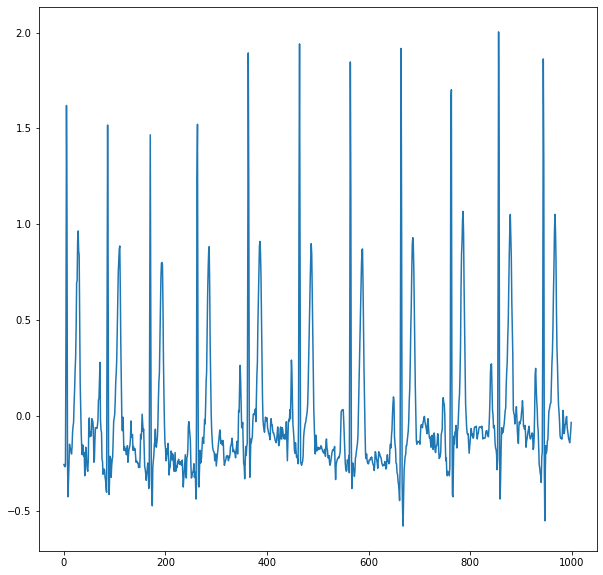

In [17]:
plt.figure(figsize=(10, 10))
plt.plot(train_dataset[8][0])

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(device=device)

'NVIDIA GeForce GTX 1060 6GB'

In [65]:
ngf = 10 #size of feature maps for gen
ndf = 10 #size of feature maps for dis
nc = 1 #num of channels
nz = 100
batch_size=32

In [72]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.emb = nn.Embedding(5, 10)
        self.feature = nn.Sequential(
#             nn.Linear(100, 200),
#             nn.ReLU(),
#             nn.Linear(200, 300),
#             nn.ReLU(),
#             nn.Linear(300, 400),
#             nn.ReLU(),
#             nn.Linear(400, 500),
#             nn.ReLU(),
#             nn.Linear(500, 600),
#             nn.ReLU(),
#             nn.Linear(600, 800),
#             nn.ReLU(),
#             nn.Linear(800, 1000),
#             nn.Tanh()
        
#             nn.ConvTranspose1d(nz, ngf * 8, 256, 1, 0, bias=False),
#             nn.BatchNorm1d(ngf*8),
#             nn.ReLU(True),

#             nn.ConvTranspose1d(ngf * 8, ngf * 4, 64, 2, 1, bias=False),
#             nn.BatchNorm1d(ngf*4),
#             nn.ReLU(True),

#             nn.ConvTranspose1d( ngf * 4, ngf * 2, 64, 2, bias=False),
#             nn.BatchNorm1d(ngf*2),
#             nn.ReLU(True),

#             nn.ConvTranspose1d(ngf * 2, ngf, 64, 2, bias=False),
#             nn.BatchNorm1d(ngf),
#             nn.ReLU(True),
#             nn.ConvTranspose1d(ngf, 1, 54, 2, bias=False),
#             nn.Tanh()
            nn.ConvTranspose1d(nz, ngf * 8, 16, 2, 1,  bias=False),
            nn.BatchNorm1d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose1d(ngf * 8, ngf * 4, 16, 2, 1, bias=False),
            nn.BatchNorm1d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose1d(ngf * 4, ngf * 2, 16, 2, 1,  bias=False),
            nn.BatchNorm1d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose1d(ngf * 2, ngf, 16, 2, 1, bias=False),
            nn.BatchNorm1d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose1d(ngf, 1, 16, 2, 1, bias=False),
            nn.Flatten(),
            nn.Linear(404, 1000),
            nn.Tanh()
           
#             nn.Linear(100, 256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(256, 512),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(512, 1000),
#             nn.Tanh()
        )

    def forward(self, x, labels):
            x=x.view(x.shape[0], 90)
            c = self.emb(labels)
            z = torch.cat([x, c], 1)
            z=torch.reshape(z, (x.shape[0], 100, 1))
            t = self.feature(z)
            return t.view(x.shape[0], 1, 1000)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.feature = nn.Sequential(
            
            nn.Conv1d(1, ndf, kernel_size = 4, padding =1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv1d(ndf, ndf * 2, kernel_size = 4, stride = 2, padding =1, bias=False),
            nn.BatchNorm1d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv1d(ndf * 2, ndf * 4, kernel_size = 4, stride = 2, padding =1, bias=False),
            nn.BatchNorm1d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv1d(ndf * 4, ndf * 8, kernel_size = 4, stride = 2, bias=False),
            nn.BatchNorm1d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            nn.Flatten(),
            nn.Linear(9840, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        z = self.feature(x)
        return z

In [73]:
epochs = 1

loss_G = nn.BCELoss()
loss_D = nn.BCELoss()

G = Generator().to(device)
D = Discriminator().to(device)


G_optimizer = optim.Adam(G.parameters(), betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), betas=(0.5, 0.999))

Epoch 0 Iteration 0: discriminator_loss 0.02030 generator_loss 4.65613
Epoch 0 Iteration 50: discriminator_loss 0.02784 generator_loss 7.16043
Epoch 0 Iteration 100: discriminator_loss 0.04096 generator_loss 4.51567
Epoch 0 Iteration 150: discriminator_loss 0.00362 generator_loss 9.13638
Epoch 0 Iteration 200: discriminator_loss 0.01000 generator_loss 7.15522
Epoch 0 Iteration 250: discriminator_loss 0.00604 generator_loss 16.16920
Epoch 0 Iteration 300: discriminator_loss 0.00190 generator_loss 10.40928
Epoch 0 Iteration 350: discriminator_loss 0.00086 generator_loss 11.38725
Epoch 0 Iteration 400: discriminator_loss 0.02395 generator_loss 7.11120
Epoch 0 Iteration 450: discriminator_loss 0.00251 generator_loss 13.60300


KeyboardInterrupt: 

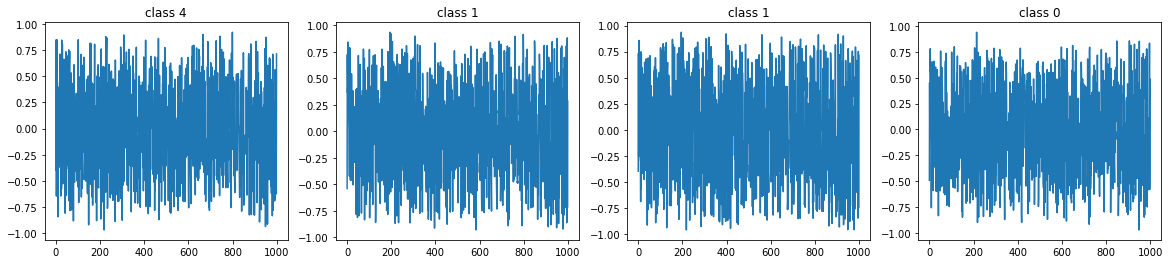

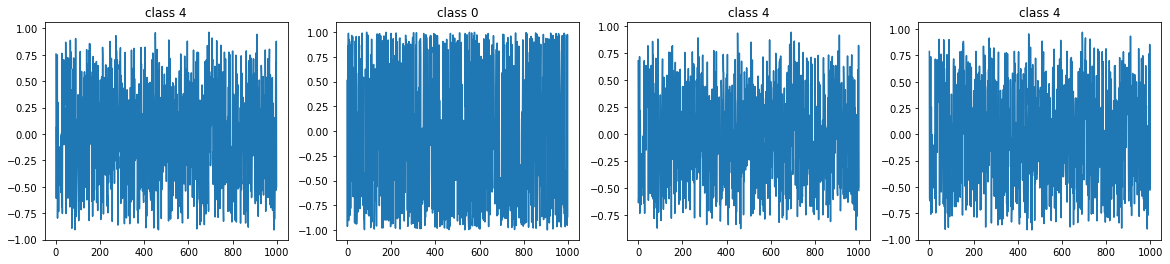

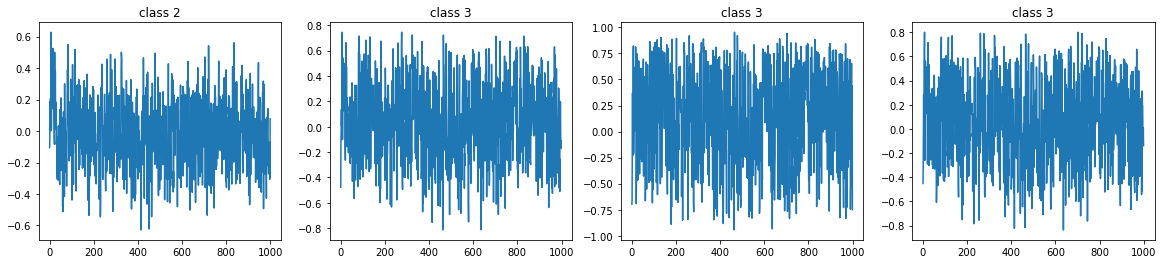

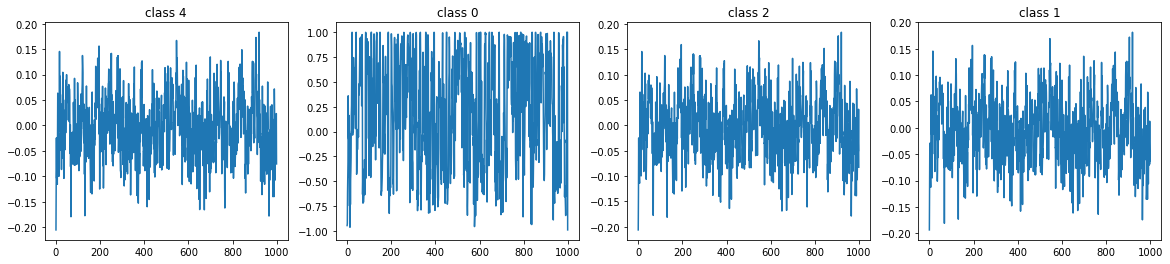

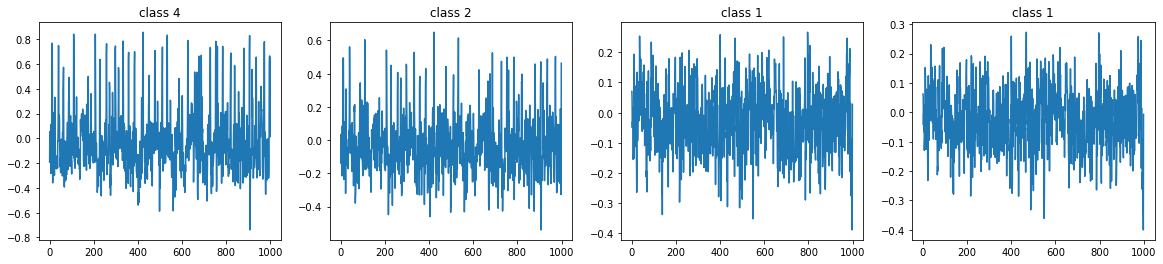

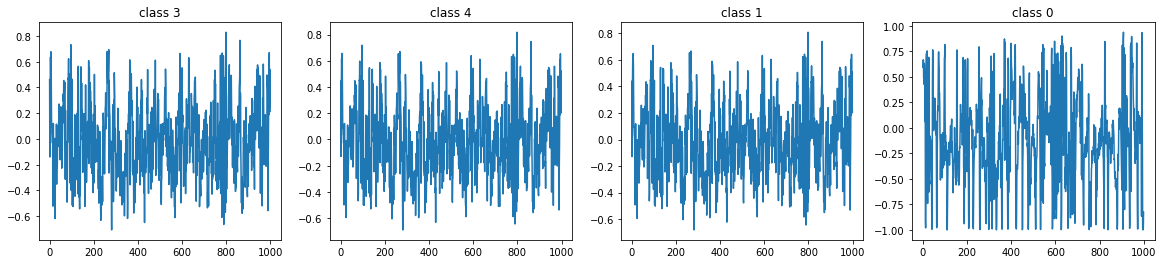

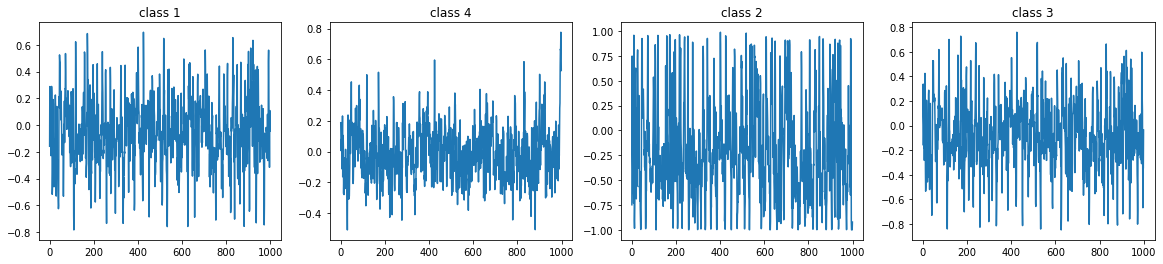

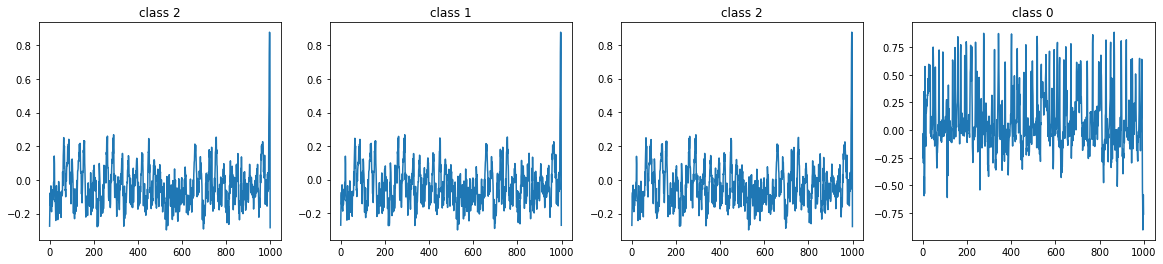

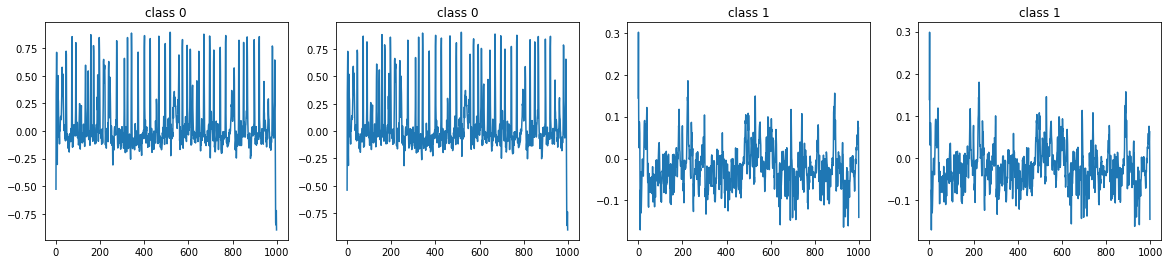

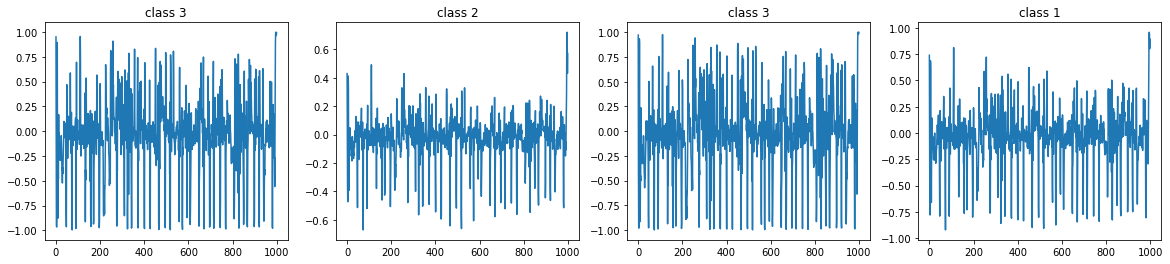

In [74]:
Gen_loss=[]
Dis_loss=[]
for epoch in range(epochs):
    for idx, (sig, labs) in enumerate(train_loader):
        for k in range(5):
            real_inputs = sig.to(device)
            real_inputs = real_inputs.reshape(real_inputs.shape[0], 1, real_inputs.shape[1])
            real_outputs = D(real_inputs.float())
            real_label = torch.ones(real_inputs.shape[0], 1).to(device)
            

            noise = torch.rand(real_inputs.shape[0], 1, 90).to(device)
            fake_class_labels = torch.LongTensor(np.random.randint(0, 5, real_inputs.shape[0])).cuda()
            fake_inputs = G(noise, fake_class_labels)
            fake_outputs = D(fake_inputs)
            fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)

            outputs = torch.cat([real_outputs, fake_outputs], 0)
            targets = torch.cat([real_label, fake_label], 0)

            D_loss = loss_D(outputs, targets)

            D_optimizer.zero_grad()
            D_loss.backward()
            D_optimizer.step()


      
        noise = torch.torch.rand(real_inputs.shape[0], 1, 90).to(device)
        fake_class_labels = torch.LongTensor(np.random.randint(0, 5, real_inputs.shape[0])).cuda()
        fake_inputs = G(noise, fake_class_labels)

        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones(fake_outputs.shape[0], 1).to(device)

        G_loss = loss_G(fake_outputs, fake_targets)

        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        Gen_loss.append(G_loss.item())
        Dis_loss.append(D_loss.item())

        if idx % 50 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.5f} generator_loss {:.5f}'.format(epoch, idx, D_loss.item(), G_loss.item()))
            fig, axs = plt.subplots(1, 4, figsize=(20,4))
            noise = torch.rand(4, 1, 90, device=device)
            fake_class_labels = torch.LongTensor(np.random.randint(0, 5, 4)).cuda()
            output = G(noise, fake_class_labels)
            for i in range(4): 
                axs[i].plot(output[i][0].detach().cpu())
                axs[i].title.set_text(f'class {fake_class_labels[i]}')
        

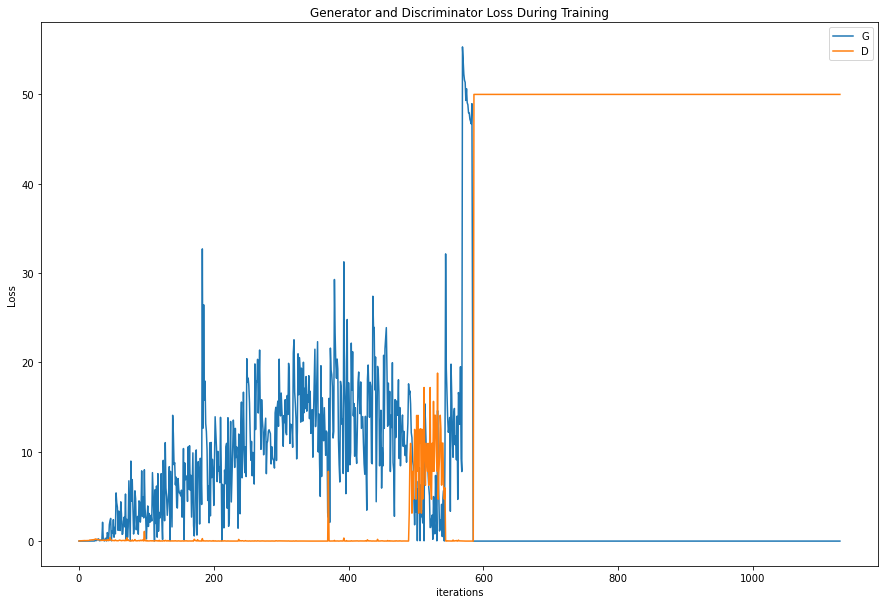

In [60]:
plt.figure(figsize=(15,10))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(Gen_loss,label="G")
plt.plot(Dis_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.feature = nn.Sequential(

            nn.ConvTranspose1d(nz, ngf * 8, 16, 2, 1,  bias=False),
            nn.BatchNorm1d(ngf*8),
            nn.ReLU(True),

            nn.ConvTranspose1d(ngf * 8, ngf * 4, 16, 2, 1, bias=False),
            nn.BatchNorm1d(ngf*4),
            nn.ReLU(True),

            nn.ConvTranspose1d(ngf * 4, ngf * 2, 16, 2, 1,  bias=False),
            nn.BatchNorm1d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose1d(ngf * 2, ngf, 16, 2, 1, bias=False),
            nn.BatchNorm1d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose1d(ngf, 1, 16, 2, 1, bias=False),
            nn.Flatten(),
            nn.Linear(404, 1000),
            nn.Tanh()

        )
    def forward(self, x):
        return(self.feature(x))
        

In [ ]:
epochs = 50

loss_G = nn.BCELoss()
loss_D = nn.BCELoss()

G = Generator().to(device)
D = Discriminator().to(device)


G_optimizer = optim.Adam(G.parameters(), betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), betas=(0.5, 0.999))

In [474]:
n = torch.randn(2, 100, 1).cuda()

In [475]:
y = G(n)
y.shape

torch.Size([2, 1000])

In [476]:
y

tensor([[-0.1653, -0.0549,  0.1183,  ...,  0.0756, -0.0056,  0.0189],
        [ 0.0262, -0.0569,  0.0802,  ..., -0.0135,  0.0095,  0.0618]],
       device='cuda:0', grad_fn=<TanhBackward0>)

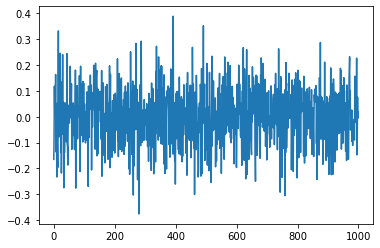

In [477]:
plt.plot(y[0].detach().cpu())